In [20]:
import ROOT
import my_library.common_analysis_tools as ct
import my_library.constants as constants
import my_library.kinematic_cuts as cuts
import numpy as np

In [21]:
ROOT.EnableImplicitMT()

In [22]:
ROOT.gInterpreter.Declare("""
double PositiveVanhove
""")

In [23]:
def define_vanhove(channel, run_period, data_type, thrown=False, filtered=True):
    if data_type not in ['signal', 'data', 'phasespace']:
        return None

    if thrown: filtered=False
    df = ct.get_dataframe(channel, run_period, data_type, thrown=thrown, filtered=filtered)

    if not thrown:
        proton = 'p'
        if channel == 'pipkmks':
            pion = 'pip1'
            kaon = 'km'
        else:
            pion = 'pim1'
            kaon = 'kp'
    else: 
        proton = 'Proton'
        if channel == 'pipkmks':
            pion = 'PiPlus1'
            kaon = 'KMinus'
            ks = 'PiPlus2_{0} + PiMinus_{0}'
        else:
            pion = 'PiMinus1'
            kaon = 'KPlus'
            ks = 'PiMinus2_{0} + PiPlus_{0}'
        df = df.Define('ks_px', ks.format('px'))
        df = df.Define('ks_py', ks.format('py'))
        df = df.Define('ks_pz', ks.format('pz'))
        df = df.Define('ks_E', ks.format('E'))
        df = df.Define('ks_m', 'sqrt(ks_E*ks_E - ks_px*ks_px - ks_py*ks_py - ks_pz*ks_pz)')

    # define beam/target CM frame
    df = df.Define("beam_p4", "ROOT::Math::PxPyPzEVector(0.0, 0.0, e_beam, e_beam)")
    df = df.Define("target_p4", "ROOT::Math::PxPyPzEVector(0.0, 0.0, 0.0, 0.938272)")
    # recoil proton, kkpi, kk, pion lab frame vectors
    df = df.Define('p_p4', f'ROOT::Math::PxPyPzEVector({proton}_px, {proton}_py, {proton}_pz, {proton}_E)')
    df = df.Define(f'{pion}_p4', f'ROOT::Math::PxPyPzEVector({pion}_px, {pion}_py, {pion}_pz, {pion}_E)')
    df = df.Define(f'{kaon}_p4', f'ROOT::Math::PxPyPzEVector({kaon}_px, {kaon}_py, {kaon}_pz, {kaon}_E)')
    df = df.Define(f'ks_p4', 'ROOT::Math::PxPyPzEVector(ks_px, ks_py, ks_pz, ks_E)')
    # boosting to CM frame
    df = df.Define('center_of_mass_p4', f'(p_p4 + {pion}_p4 + {kaon}_p4 + ks_p4)')
    df = df.Define('cm_boost_vector', f'center_of_mass_p4.BoostToCM()')
    df = df.Define('cm_boost', "ROOT::Math::Boost(cm_boost_vector)")
    df = df.Define('beam_p4_cm', 'cm_boost(beam_p4)')
    df = df.Define('target_p4_cm', 'cm_boost(target_p4)')
    df = df.Define('p_p4_cm', 'cm_boost(p_p4)')
    df = df.Define(f'{pion}_p4_cm', f'cm_boost({pion}_p4)')
    df = df.Define(f'{kaon}_p4_cm', f'cm_boost({kaon}_p4)')
    df = df.Define('ks_p4_cm', 'cm_boost(ks_p4)')
    # define vanhove variables
    df = df.Define('q1', f'{pion}_p4_cm.Pz()')
    df = df.Define('q2', f'{kaon}_p4_cm.Pz()')
    df = df.Define('q3', 'ks_p4_cm.Pz()')
    df = df.Define('q4', 'p_p4_cm.Pz()')
    df = df.Define('z', 'q1')
    df = df.Define('x', 'sqrt(3.0/8.0)*(q3-q2)')
    df = df.Define('y', 'sqrt(1.0/8.0)*( (2.0*q1) + (3.0*q2) + (3.0*q3) )')
    df = df.Define('theta_vanhove', 'TMath::RadToDeg() * atan2(sqrt(x*x + y*y), z)')
    df = df.Define('phi_vanhove', 'TMath::RadToDeg() * atan2(y, x)')



    return df

In [24]:
df_pipkmks = define_vanhove('pipkmks', 'gluex1', 'data')
df_pimkpks = define_vanhove('pimkpks', 'gluex1', 'data')


In [25]:
hist_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo2D(('vanhove_pipkmks', 'Van Hove #theta vs #phi for #pi^{+}K^{-}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
hist_pimkpks = df_pimkpks.Filter(cuts.KSTAR_ALL_CUT_PIMKPKS).Histo2D(('vanhove_pimkpks', 'Van Hove #theta vs #phi for #pi^{-}K^{+}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
# hist_theta_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D(('vanhove_theta', 'Van Hove #theta for #pi^{+}K^{-}K_{S}^{0}', 100, 0, 180), 'theta_vanhove')
hist_theta_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D('theta_vanhove')
hist_kkpi_pipkms = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D(('pipkmks', 'M(KK#pi)', 90, 1.1, 2.0), 'pipkmks_m')

# no kstar cuts
# hist_pipkmks = df_pipkmks.Histo2D(('vanhove_pipkmks', 'Van Hove #theta vs #phi for #pi^{+}K^{-}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
# hist_pimkpks = df_pimkpks.Histo2D(('vanhove_pimkpks', 'Van Hove #theta vs #phi for #pi^{-}K^{+}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
# # hist_theta_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D(('vanhove_theta', 'Van Hove #theta for #pi^{+}K^{-}K_{S}^{0}', 100, 0, 180), 'theta_vanhove')
# hist_theta_pipkmks = df_pipkmks.Histo1D('theta_vanhove')
# hist_kkpi_pipkms = df_pipkmks.Histo1D(('pipkmks', 'M(KK#pi)', 90, 1.1, 2.0), 'pipkmks_m')
# hist_ppi = df_pipkmks.Histo1D(('m_ppi', 'M(p#pi)', 200, 0.8, 3.0), 'ppip_m')

In [26]:
# cols = ROOT.vector('string')(); cols.push_back('q4'); cols.push_back('q1'); cols.push_back('q2'); cols.push_back('q3'); cols.push_back("x"); cols.push_back("y"); cols.push_back("z"); cols.push_back("theta_vanhove"); cols.push_back("phi_vanhove");
# print(df_pipkmks.Display(cols, 100).Print())

In [27]:
# stats_phi = df_pipkmks.Stats('phi_vanhove')
# stats_theta = df_pipkmks.Stats('theta_vanhove')
# print(stats_phi.Print())
# print(stats_theta.Print())

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


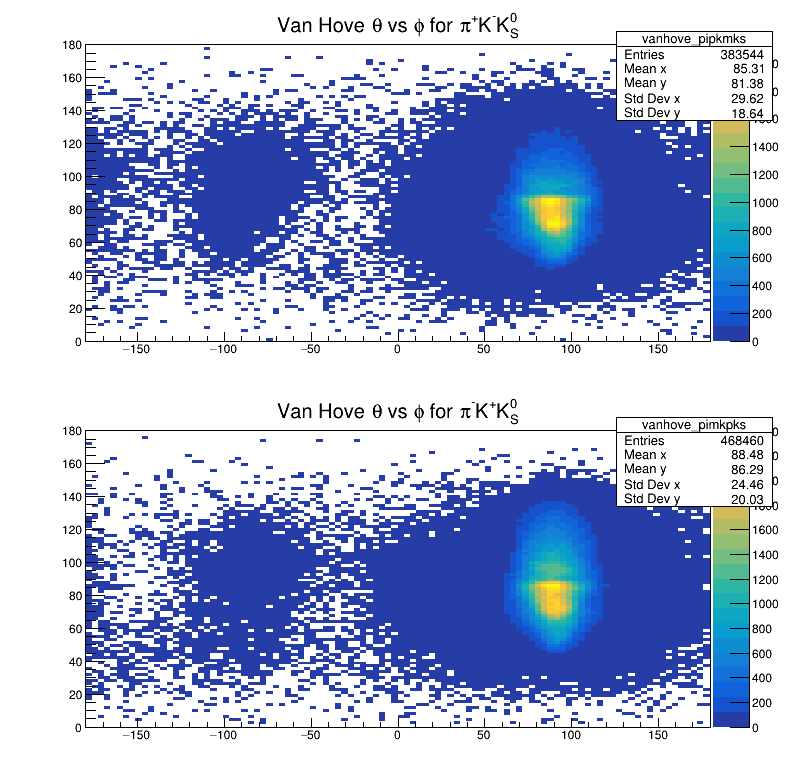

In [28]:
c = ROOT.TCanvas('c', 'c', 800, 800)
c.Divide(1, 2)
c.cd(1)
hist_pipkmks.Draw('colz')
c.cd(2)
hist_pimkpks.Draw('colz')
c.Draw()


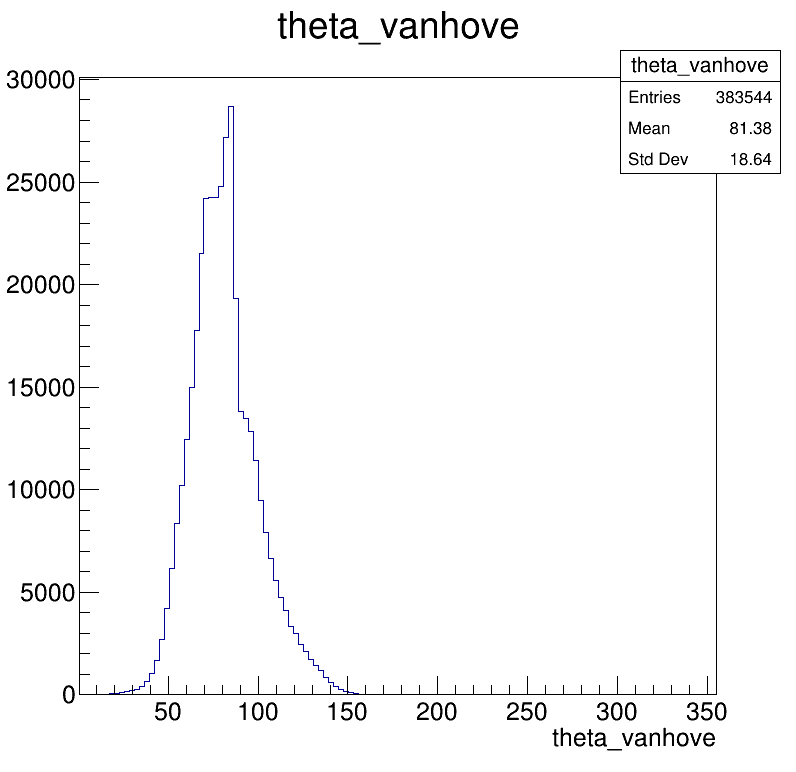

In [29]:
c.Clear()
hist_theta_pipkmks.Draw()
c.Draw()

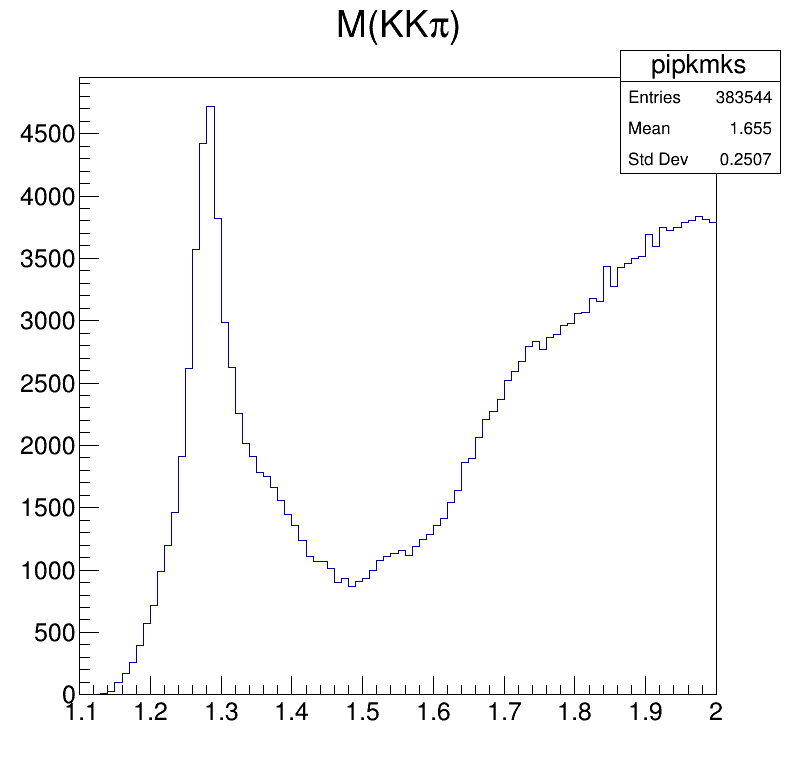

In [30]:
c.Clear()
hist_kkpi_pipkms.Draw()
c.Draw()

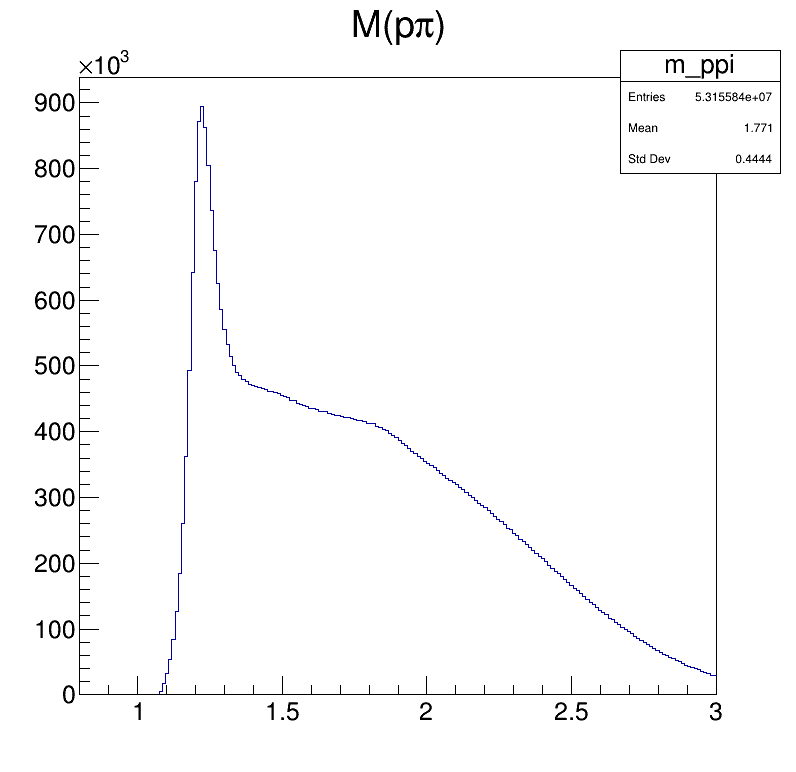

In [31]:
c.Clear()
hist_ppi.Draw()
c.Draw()